# Network Pruning
This notebook contains some methods I tried to reduce the size of a network (according to question 4)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import networkx as nx
import copy
import math

### Importing the network

In [2]:
with open("network.json", "r") as f1:
    network = json.load(f1)

### Common Functions
Functions common to all techniques

In [3]:
def get_network_components(network: dict) -> list:
    """Returns a list of sets where each set is a connected cluster of nodes"""
    def find_node_cluster(cluster_map, node):
        """Returns the head node of a cluster if the node is in a cluster otherwise it returns None"""
        for head_node, node_set in cluster_map.items():
            if node in node_set:
                return head_node
        
        return None

    # Isolating the different components
    cluster_map = {}
    for node, neighbours in tqdm(network.items()):
        # 1) Check if current node is in a cluster
        current_node_cluster = find_node_cluster(cluster_map, node)

        # 2) If node is not in a cluster create a new one
        if current_node_cluster is None:
            current_node_cluster = node
            cluster_map[current_node_cluster] = set([node])
        
        clusters_to_be_merged = set()
        for neighbour in neighbours.keys():
            # 3) If neighbour is part of another cluster mark the cluster for merging
            neighbour_cluster = find_node_cluster(cluster_map, neighbour)
            if (neighbour_cluster is not None) and (neighbour_cluster != current_node_cluster):
                clusters_to_be_merged.add(neighbour_cluster)
            elif neighbour_cluster != current_node_cluster:
                # 4) Add neighbouring nodes to the current cluster
                cluster_map[current_node_cluster].add(neighbour)
        
        # 5) Merge the clusters that need to be merged
        for cluster in clusters_to_be_merged:
            cluster_content = cluster_map[cluster]
            cluster_map[current_node_cluster] = cluster_map[current_node_cluster].union(cluster_content)
            cluster_map.pop(cluster)
    
    return list(cluster_map.values())

def get_giant_component_size(network: dict) -> list:
    components = get_network_components(network)
    return max([len(c) for c in components])

### 1) Net Normalised Weights based edge removal
Net normalised weighted are inspired by Page Rank where the weights of each edge are the average normalised weights for each node.

net_normalised_weight(n1, n2) = ((weight(n1, n2) / sigma(weight(n1, i))) + (weight(n1, n2) / sigma(weight(i, n2)))) / 2 

In [4]:
# 1) Normalise all edge weights relative to each node
normalised_network = copy.deepcopy(network)
for node, neighbours in tqdm(network.items()):
    sum_of_weights = sum(neighbours.values())
    for neighbour in neighbours.keys():
        normalised_network[node][neighbour] /= sum_of_weights

# 2) Take the average of each normalised value relative to each node
net_normalised_network = copy.deepcopy(normalised_network)
for node, neighbours in tqdm(network.items()):
    for neighbour in neighbours.keys():
        net_norm_weight = (normalised_network[node][neighbour] + normalised_network[neighbour][node]) / 2
        net_normalised_network[node][neighbour] = net_norm_weight
        net_normalised_network[neighbour][node] = net_norm_weight

100%|██████████| 993/993 [00:00<00:00, 147259.62it/s]


100%|██████████| 993/993 [00:00<00:00, 529285.03it/s]


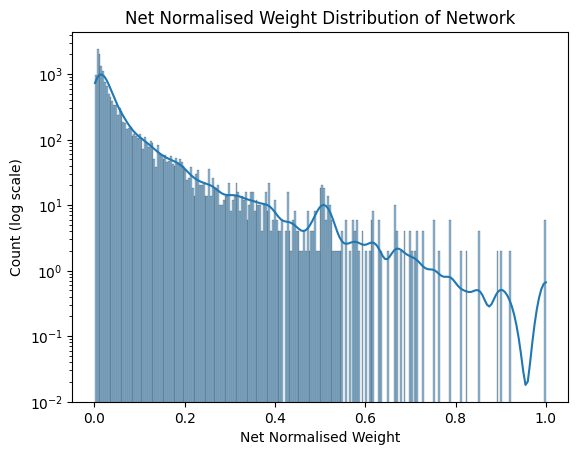

Net Normalised Weight Distribution Statistics:
count    16224.000000
mean         0.061206
std          0.101566
min          0.001222
25%          0.010494
50%          0.022408
75%          0.061844
max          1.000000
dtype: float64


In [5]:
net_norm_weight_distribution = []
for node, neighbours in tqdm(net_normalised_network.items()):
    for neighbour, weight in neighbours.items():
        net_norm_weight_distribution.append(weight)

sns.histplot(data=net_norm_weight_distribution, kde=True)
plt.title('Net Normalised Weight Distribution of Network')
plt.xlabel('Net Normalised Weight')
plt.yscale("log")
plt.ylabel("Count (log scale)")
plt.show()

print(f"Net Normalised Weight Distribution Statistics:\n{pd.Series(net_norm_weight_distribution).describe()}")

#### 1a) Hard Minimum for net norm weight for whole graph
Calculate a min net norm weight such that if all edges below that min are removed k_max will be enforced

In [6]:
def find_hard_minimum_net_norm_weight(net_norm_network: dict, k_max: int) -> float:
    min_net_norm_weight = 0.0
    for node, neighbours in tqdm(net_norm_network.items()):
        if len(neighbours) > k_max:
            no_nodes_to_remove = len(neighbours) - k_max
            weights_list = list(neighbours.values())
            weights_list.sort()
            candidate_min_net_norm_weight = weights_list[no_nodes_to_remove - 1]
            if candidate_min_net_norm_weight > min_net_norm_weight:
                min_net_norm_weight = candidate_min_net_norm_weight
    
    return min_net_norm_weight

In [7]:
def prune_network_on_min_net_norm_weight(net_norm_network: dict, min_net_norm_weight: float) -> dict:
    pruned_network = copy.deepcopy(net_norm_network)
    for node, neighbours in tqdm(net_norm_network.items()):
        for neighbour, weight in neighbours.items():
            if weight <= min_net_norm_weight:
                pruned_network[node].pop(neighbour)
    
    return pruned_network

100%|██████████| 993/993 [00:00<00:00, 682889.63it/s]


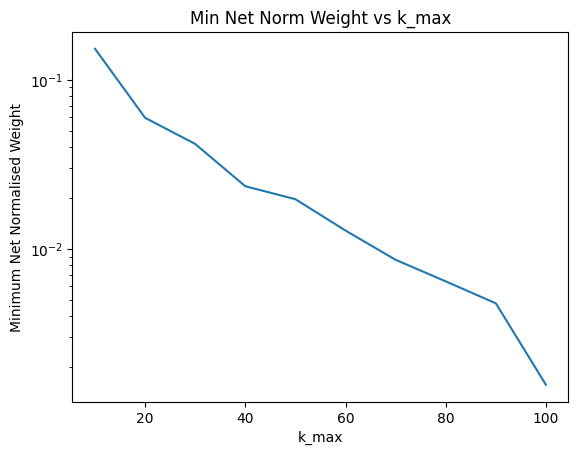

In [8]:
# Analysing relation between k_max and min_net_norm_weight
min_net_norm_weight_list = []
k_max_list = list(range(100, 0, -10))

for k_max in k_max_list:
    min_net_norm_weight_list.append(find_hard_minimum_net_norm_weight(net_norm_network=net_normalised_network, k_max=k_max))

sns.lineplot(x=k_max_list, y=min_net_norm_weight_list)
plt.title('Min Net Norm Weight vs k_max')
plt.xlabel('k_max')
plt.yscale("log")
plt.ylabel("Minimum Net Normalised Weight")
plt.show()

100%|██████████| 993/993 [00:00<00:00, 354282.40it/s]


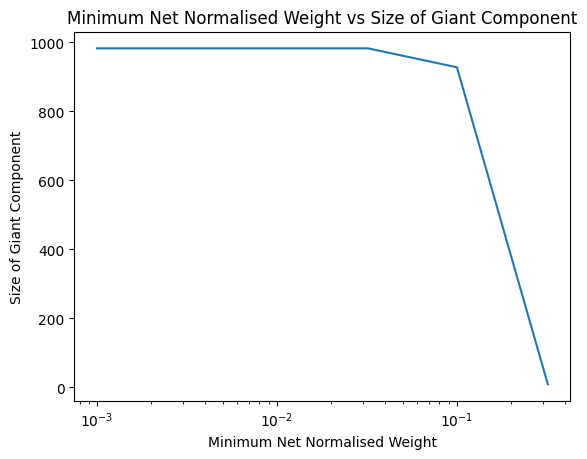

In [9]:
min_net_norm_weight_list = [3.2e-1, 1e-1, 3.2e-2, 1e-2, 3.2e-3, 1e-3]
giant_component_size_list = []
for min_norm in min_net_norm_weight_list:
    giant_component_size_list.append(get_giant_component_size(prune_network_on_min_net_norm_weight(net_norm_network=net_normalised_network, min_net_norm_weight=min_norm)))

sns.lineplot(x=min_net_norm_weight_list, y=giant_component_size_list)
plt.title('Minimum Net Normalised Weight vs Size of Giant Component')
plt.xlabel('Minimum Net Normalised Weight')
plt.xscale("log")
plt.ylabel("Size of Giant Component")
plt.show()

100%|██████████| 993/993 [00:00<00:00, 82114.78it/s]


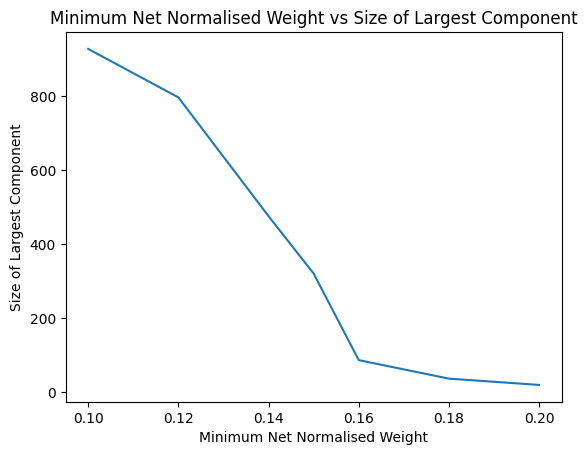

In [10]:
min_net_norm_weight_list = [0.1, 0.12, 0.14, 0.15, 0.16, 0.18, 0.2]
giant_component_size_list = []
for min_norm in min_net_norm_weight_list:
    giant_component_size_list.append(get_giant_component_size(prune_network_on_min_net_norm_weight(net_norm_network=net_normalised_network, min_net_norm_weight=min_norm)))

sns.lineplot(x=min_net_norm_weight_list, y=giant_component_size_list)
plt.title('Minimum Net Normalised Weight vs Size of Largest Component')
plt.xlabel('Minimum Net Normalised Weight')
# plt.xscale("log")
plt.ylabel("Size of Largest Component")
plt.show()

### 2) Net Normalised Edge Importance based removal 
Same as net normalised weight based edge removal but the we consider all edges to have the same initial weight  
Net normalised edge importance are inspired by Page Rank where the importance of each edge are the average normalised weights for each node.

net_normalised_edge_importance(n1, n2) = ((1 / degree(n1)) + (1 / degree(n2))) / 2 

In [11]:
# 1) Normalise all edge importance relative to each node
normalised_network = copy.deepcopy(network)
for node, neighbours in tqdm(network.items()):
    sum_of_weights = len(neighbours.values())
    for neighbour in neighbours.keys():
        normalised_network[node][neighbour] = 1/sum_of_weights

# 2) Take the average of each normalised value relative to each node
net_normalised_network = copy.deepcopy(normalised_network)
for node, neighbours in tqdm(network.items()):
    for neighbour in neighbours.keys():
        net_norm_weight = (normalised_network[node][neighbour] + normalised_network[neighbour][node]) / 2
        net_normalised_network[node][neighbour] = net_norm_weight
        net_normalised_network[neighbour][node] = net_norm_weight

100%|██████████| 993/993 [00:00<00:00, 161751.67it/s]


100%|██████████| 993/993 [00:00<00:00, 384752.32it/s]


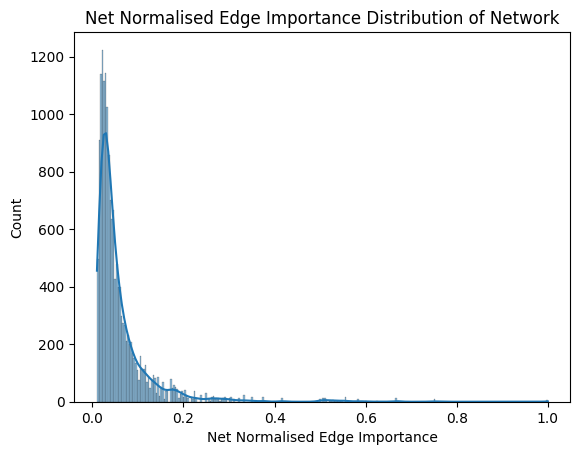

Net Normalised Edge Importance Distribution Statistics:
count    16224.000000
mean         0.061206
std          0.071296
min          0.010001
25%          0.024863
50%          0.038856
75%          0.068994
max          1.000000
dtype: float64


In [12]:
net_norm_weight_distribution = []
for node, neighbours in tqdm(net_normalised_network.items()):
    for neighbour, weight in neighbours.items():
        net_norm_weight_distribution.append(weight)

sns.histplot(data=net_norm_weight_distribution, kde=True)
plt.title('Net Normalised Edge Importance Distribution of Network')
plt.xlabel('Net Normalised Edge Importance')
# plt.yscale("log")
plt.ylabel("Count")
plt.show()

print(f"Net Normalised Edge Importance Distribution Statistics:\n{pd.Series(net_norm_weight_distribution).describe()}")

#### 2a) Hard Minimum for net norm edge importance for whole graph
Calculate a min net norm edge importance such that if all edges below that min are removed k_max will be enforced

100%|██████████| 993/993 [00:00<00:00, 953076.40it/s]


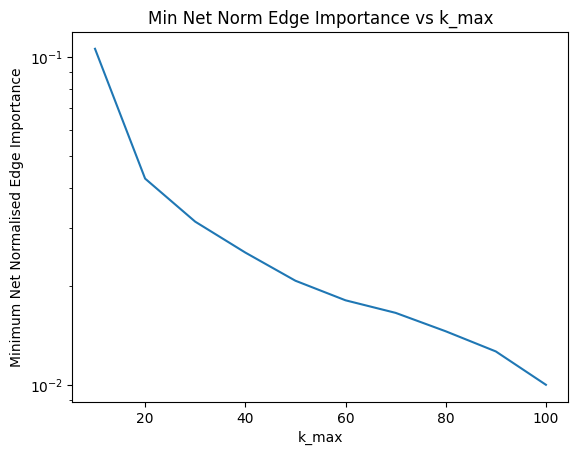

In [13]:
# Analysing relation between k_max and min_net_norm_weight
min_net_norm_weight_list = []
k_max_list = list(range(100, 0, -10))

for k_max in k_max_list:
    min_net_norm_weight_list.append(find_hard_minimum_net_norm_weight(net_norm_network=net_normalised_network, k_max=k_max))

sns.lineplot(x=k_max_list, y=min_net_norm_weight_list)
plt.title('Min Net Norm Edge Importance vs k_max')
plt.xlabel('k_max')
plt.yscale("log")
plt.ylabel("Minimum Net Normalised Edge Importance")
plt.show()

100%|██████████| 993/993 [00:00<00:00, 358213.11it/s]


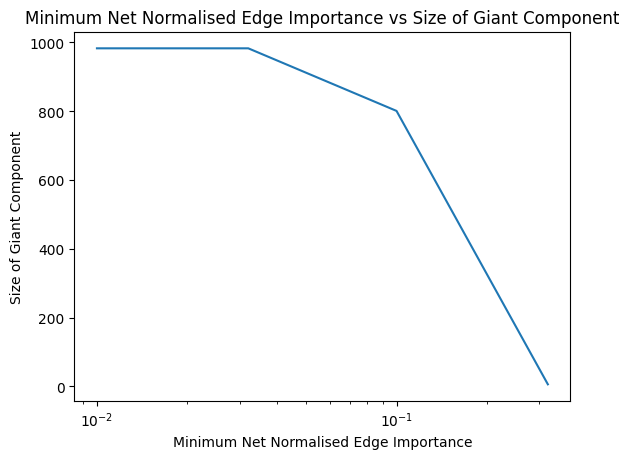

In [14]:
min_net_norm_weight_list = [3.2e-1, 1e-1, 3.2e-2, 1e-2]
giant_component_size_list = []
for min_norm in min_net_norm_weight_list:
    giant_component_size_list.append(get_giant_component_size(prune_network_on_min_net_norm_weight(net_norm_network=net_normalised_network, min_net_norm_weight=min_norm)))

sns.lineplot(x=min_net_norm_weight_list, y=giant_component_size_list)
plt.title('Minimum Net Normalised Edge Importance vs Size of Giant Component')
plt.xlabel('Minimum Net Normalised Edge Importance')
plt.xscale("log")
plt.ylabel("Size of Giant Component")
plt.show()

### 3) Max Normalised Edge Importance  

Max normalised edge importance are inspired by Page Rank where the importance of each edge is the max normalised weights for each node.

max_normalised_edge_importance(n1, n2) = max((1 / degree(n1)) + (1 / degree(n2)))

In [15]:
# 1) Normalise all edge importance relative to each node
normalised_network = copy.deepcopy(network)
for node, neighbours in tqdm(network.items()):
    sum_of_weights = len(neighbours.values())
    for neighbour in neighbours.keys():
        normalised_network[node][neighbour] = 1/sum_of_weights

# 2) Take the maximum of each normalised value relative to each node
max_normalised_network = copy.deepcopy(normalised_network)
for node, neighbours in tqdm(network.items()):
    for neighbour in neighbours.keys():
        max_norm_weight = max((normalised_network[node][neighbour], normalised_network[neighbour][node]))
        max_normalised_network[node][neighbour] = max_norm_weight
        max_normalised_network[neighbour][node] = max_norm_weight

100%|██████████| 993/993 [00:00<00:00, 127092.36it/s]


100%|██████████| 993/993 [00:00<00:00, 471520.87it/s]


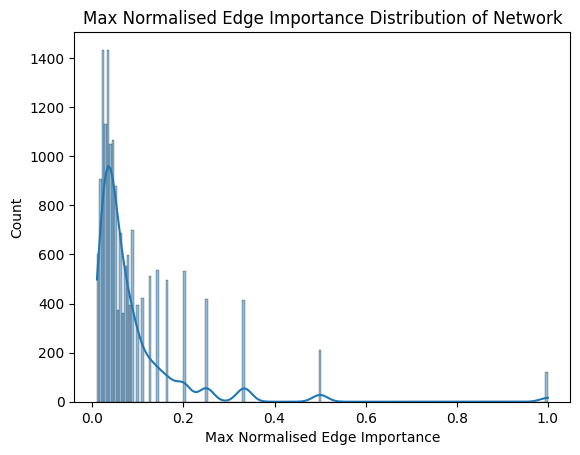

Max Normalised Edge Importance Distribution Statistics:
count    16224.000000
mean         0.088357
std          0.114912
min          0.010101
25%          0.031250
50%          0.052632
75%          0.100000
max          1.000000
dtype: float64


In [16]:
max_norm_weight_distribution = []
for node, neighbours in tqdm(max_normalised_network.items()):
    for neighbour, weight in neighbours.items():
        max_norm_weight_distribution.append(weight)

sns.histplot(data=max_norm_weight_distribution, kde=True)
plt.title('Max Normalised Edge Importance Distribution of Network')
plt.xlabel('Max Normalised Edge Importance')
# plt.yscale("log")
plt.ylabel("Count")
plt.show()

print(f"Max Normalised Edge Importance Distribution Statistics:\n{pd.Series(max_norm_weight_distribution).describe()}")

#### 3a) Hard Minimum for max norm edge importance for whole graph
Calculate a min max norm edge importance such that if all edges below that min are removed k_max will be enforced

100%|██████████| 993/993 [00:00<00:00, 995921.54it/s]


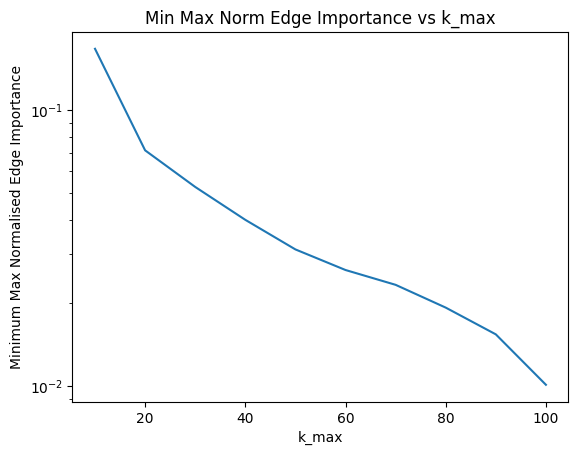

In [17]:
# Analysing relation between k_max and min_net_norm_weight
min_max_norm_weight_edge_imp = []
k_max_list = list(range(100, 0, -10))

for k_max in k_max_list:
    min_max_norm_weight_edge_imp.append(find_hard_minimum_net_norm_weight(net_norm_network=max_normalised_network, k_max=k_max))

sns.lineplot(x=k_max_list, y=min_max_norm_weight_edge_imp)
plt.title('Min Max Norm Edge Importance vs k_max')
plt.xlabel('k_max')
plt.yscale("log")
plt.ylabel("Minimum Max Normalised Edge Importance")
plt.show()

100%|██████████| 993/993 [00:00<00:00, 314074.65it/s]


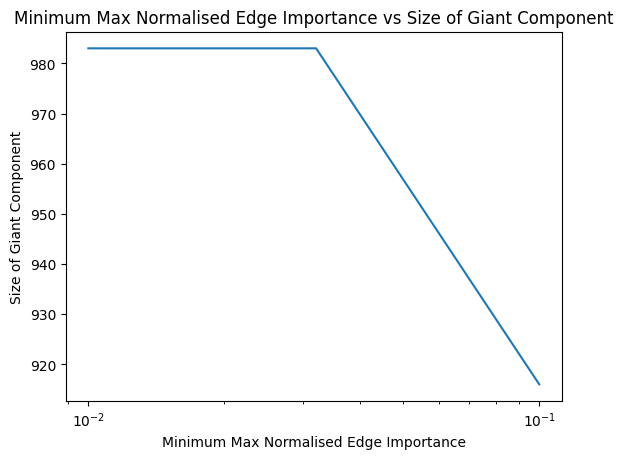

In [18]:
min_max_norm_weight_list = [1e-1, 3.2e-2, 1e-2]
giant_component_size_list = []
for min_norm in min_max_norm_weight_list:
    giant_component_size_list.append(get_giant_component_size(prune_network_on_min_net_norm_weight(net_norm_network=max_normalised_network, min_net_norm_weight=min_norm)))

sns.lineplot(x=min_max_norm_weight_list, y=giant_component_size_list)
plt.title('Minimum Max Normalised Edge Importance vs Size of Giant Component')
plt.xlabel('Minimum Max Normalised Edge Importance')
plt.xscale("log")
plt.ylabel("Size of Giant Component")
plt.show()

100%|██████████| 993/993 [00:00<00:00, 80095.07it/s]


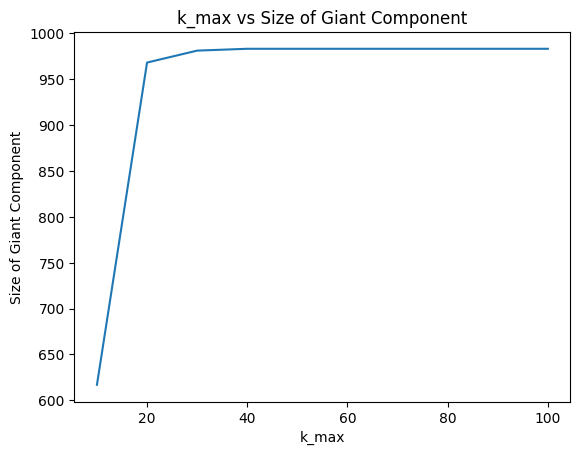

In [19]:
# Analysing relation between k_max and min_net_norm_weight
min_max_norm_weight_edge_imp = []
k_max_list = list(range(100, 0, -10))
for k_max in k_max_list:
    min_max_norm_weight_edge_imp.append(find_hard_minimum_net_norm_weight(net_norm_network=max_normalised_network, k_max=k_max))

giant_component_size_list = []
for min_norm in min_max_norm_weight_edge_imp:
    giant_component_size_list.append(get_giant_component_size(prune_network_on_min_net_norm_weight(net_norm_network=max_normalised_network, min_net_norm_weight=min_norm)))

sns.lineplot(x=k_max_list, y=giant_component_size_list)
plt.title('k_max vs Size of Giant Component')
plt.xlabel('k_max')
plt.ylabel("Size of Giant Component")
plt.show()

#### 3b) Reducing degree of each node according to scale-free property  
Here, we calculate a new_gamma based on k_max and scale-free property then we reduce the degree of each node to the degree with the same probability in the new scale-free network by removing edges with the lowest importance in each node.

$$ \gamma_{new} = 1 + {ln(N) \over ln(k_{max})} $$

$$ k_{new} = e^{{\gamma_{old} \over \gamma_{new}}ln(k_{old})} $$

where,

$$ \gamma_{old} = 2.5 $$
$$ N = 993 $$

In [38]:
def find_new_gamma(network_size: int, k_max: int) -> float:
    """Takes N and k_max returns the corresponding gamma"""
    return 1 + math.log(network_size, k_max)

def find_new_degree_of_node(gamma_new: float, k_old: int, gamma_old=2.5) -> int:
    return int(round(k_old ** (gamma_old / gamma_new)))

In [34]:
def sort_dict_keys_on_value(dict1: dict, descending=False) -> list:
    """Takes a dictionary and returns a list of items which are sorted based on value in the dict"""
    def partition(arr,l,h):
        i = ( l - 1 )
        x = arr[h][1]
    
        for j in range(l , h):
            if arr[j][1] <= x:
    
                # increment index of smaller element
                i = i+1
                arr[i],arr[j] = arr[j],arr[i]
    
        arr[i+1], arr[h] = arr[h], arr[i+1]
        return (i+1)
    
    def quickSortIterative(arr,l,h):
        """
        Function to do Quick sort  
        arr[] --> Array to be sorted,   
        l --> Starting index,  
        h --> Ending index 
        """
    
        # Create an auxiliary stack
        size = h - l + 1
        stack = [0] * (size)
    
        # initialize top of stack
        top = -1
    
        # push initial values of l and h to stack
        top = top + 1
        stack[top] = l
        top = top + 1
        stack[top] = h
    
        # Keep popping from stack while is not empty
        while top >= 0:
    
            # Pop h and l
            h = stack[top]
            top = top - 1
            l = stack[top]
            top = top - 1
    
            # Set pivot element at its correct position in
            # sorted array
            p = partition(arr, l, h)
    
            # If there are elements on left side of pivot,
            # then push left side to stack
            if p-1 > l:
                top = top + 1
                stack[top] = l
                top = top + 1
                stack[top] = p - 1
    
            # If there are elements on right side of pivot,
            # then push right side to stack
            if p+1 < h:
                top = top + 1
                stack[top] = p + 1
                top = top + 1
                stack[top] = h
    
    items = list(dict1.items())
    quickSortIterative(items, l=0, h= len(items)-1)
    return items if not(descending) else items[::-1]

In [39]:
def prune_network_maintaining_scale_free_prop(network: dict, k_max: int, network_gamma: float) -> dict:
    """Returns a pruned network based on k_max that maintains scale free property. Pruning of edges with take place wrt to their weights."""
    gamma_new = find_new_gamma(len(network), k_max)

    # 1) Find the degree of each node
    degree_dict = {node: len(vals) for node, vals in network.items()}
    
    # 2) Get a list of nodes sorted in decreasing value of degree
    node_list = sort_dict_keys_on_value(dict1=degree_dict, descending=True)

    pruned_network = copy.deepcopy(network)
    for node, old_degree in node_list:
        # 3) Find new degree of the node and calculate no of edges to be removed
        new_degree = find_new_degree_of_node(gamma_new=gamma_new, k_old=old_degree, gamma_old=network_gamma)
        no_edges_to_be_removed = len(pruned_network[node]) - new_degree
        if no_edges_to_be_removed <= 0:
            continue

        # 3) Sort the edges according to weight
        edge_list = sort_dict_keys_on_value(dict1=pruned_network[node], descending=False)

        # 4) Pop the bottom no_edges_to_be_removed from pruned_network
        for i in range(no_edges_to_be_removed):
            pruned_network[node].pop(edge_list[i][0])
            pruned_network[edge_list[i][0]].pop(node)
        
    return pruned_network

In [41]:
pruned_network = prune_network_maintaining_scale_free_prop(network=max_normalised_network, network_gamma=2.5, k_max=75)

Pruned Network Degree Distribution Statistics:
count    993.000000
mean      13.075529
std       12.054870
min        1.000000
25%        4.000000
50%        9.000000
75%       18.000000
max       72.000000
dtype: float64


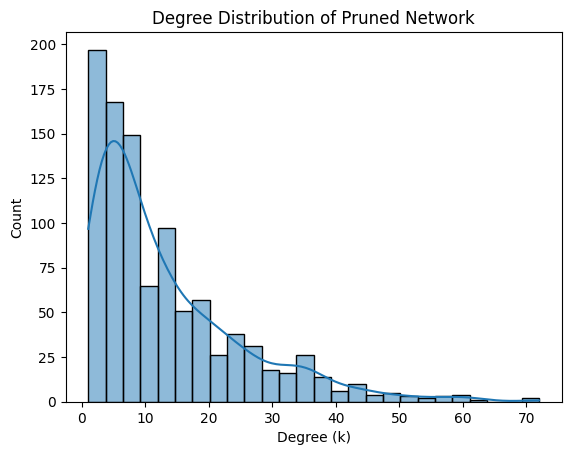

In [43]:
degree_dict = {node: len(vals) for node, vals in pruned_network.items()}
degree_distribution = list(degree_dict.values())
print(f"Pruned Network Degree Distribution Statistics:\n{pd.Series(degree_distribution).describe()}")
sns.histplot(data=degree_distribution, kde=True)
plt.title('Degree Distribution of Pruned Network')
plt.xlabel('Degree (k)')
plt.show()

100%|██████████| 993/993 [00:00<00:00, 207997.60it/s]


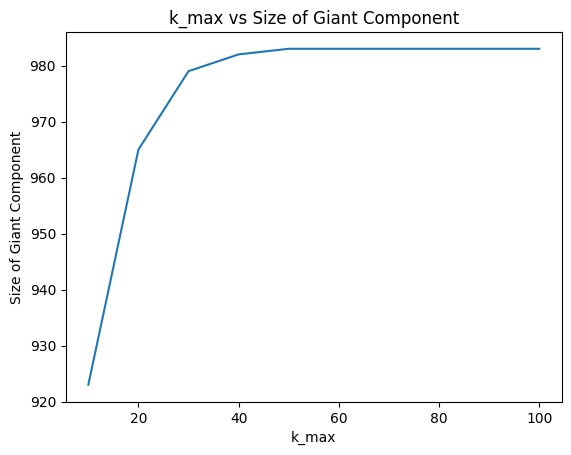

In [44]:
# Analysing relation between k_max and size of giant component
k_max_list = list(range(100, 0, -10))
giant_component_size_list = []
for k_max in k_max_list:
    giant_component_size_list.append(get_giant_component_size(prune_network_maintaining_scale_free_prop(network=max_normalised_network, network_gamma=2.5, k_max=k_max)))

sns.lineplot(x=k_max_list, y=giant_component_size_list)
plt.title('k_max vs Size of Giant Component')
plt.xlabel('k_max')
plt.ylabel("Size of Giant Component")
plt.show()

### 4) Max Normalised Weights

### 5) Page Rank Edge Importance